In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision.datasets import MNIST

In [2]:
mnist_trainset = MNIST("C:\\Users\\sadri\\Documents\\deepLearningProject\\", train=True, download=True)
mnist_testset = MNIST("C:\\Users\\sadri\\Documents\\deepLearningProject\\", train=False, download=True)

In [3]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 1, 28, 28).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 1, 28, 28).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 1, 28, 28).float()
targets_test = mnist_testset.targets[:500]

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([1000, 1, 28, 28])
targets_train torch.Size([1000])
x_valid torch.Size([500, 1, 28, 28])
targets_valid torch.Size([500])
x_test torch.Size([500, 1, 28, 28])
targets_test torch.Size([500])


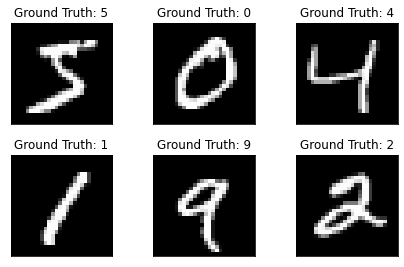

In [4]:
import matplotlib.pyplot as plt

example_data = mnist_trainset.data[:6].view(-1,1,28,28)
example_targets = targets_train[:6]

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [5]:
if torch.cuda.is_available():
    print('cuda is available!')
else:
    print('sorry, but no cuda found!')

cuda is available!


In [6]:
def listofconvnets(input_channels, num_channels, strides, nuconv,
                 trans_block = False):
    # nuconv: number of potential convolutional blocks, 1x1, 3x3, ...
    # kernel size: filter dimensions
    # stride: step size
    # padding: filling by sides
    blk = []
    if trans_block:
        for i in range(nuconv):
            blk.append(nn.Conv2d(input_channels, num_channels,
                            kernel_size=2*i+1, padding=i, stride=1))    
                            # kernel_size=2*i+1, padding=i, stride=strides))
            blk.append(nn.BatchNorm2d(num_channels))
        for i in range(nuconv+1):
            blk.append(nn.ConvTranspose2d(input_channels, num_channels,
                                kernel_size=2*i+1, padding=i, stride=1))
                            # kernel_size=2*i+1, padding=i, stride=strides))
            blk.append(nn.BatchNorm2d(num_channels))
    else:
        for i in range(nuconv):
            blk.append(nn.Conv2d(input_channels, num_channels,
                            kernel_size=2*i+1, padding=i, stride=strides))
            blk.append(nn.BatchNorm2d(num_channels))
    return blk

In [7]:
thesoft = nn.Softmax(dim=0)
class superarch(): 
    # class to define super-architecture, as in the main paper
    # it switches on/off identity layers and creates a total of
    # input*2 layers
    def __init__(self,numoflayers, nuconvnet):
        # nuconvnet: number of candidate convolutional net
        self.arch = []
        self.b = [] # hyperparameters for network selection, probabilities
        for i in range(numoflayers):
            for j in [False, True]:
                layerelms = listofconvnets(64,64,2,nuconvnet,j) # possible networks are added in here
                self.arch.append(layerelms)
                if j:
                    self.b.append(torch.rand(2*nuconvnet+1+1))
                else:
                    self.b.append(torch.rand(nuconvnet+1))
        self.b0 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), # kernel_size, ... :: 7, 2, 3
                           nn.BatchNorm2d(64), nn.ReLU(),
                           nn.MaxPool2d(kernel_size=3, stride=1, padding=1))
        self.bend = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                            nn.Flatten(), nn.Linear(64, 10))
        self.layersels = [] # current selected layers
        self.thecalcnets = [] # all calculated networks until now
        self.Iconv = [] # identity convolutional layers to decrease the data size
        for i in range(numoflayers):
            self.Iconv.append(nn.Conv2d(64, 64,kernel_size=1, stride=2))
            
    def tonetselect(self): # with given probabilities, find the candidate network
        blk = [] 
        blk.append(self.b0)
        self.layersels = []
        for ind in range(superarchlen):
            i =2*ind
            loc = torch.argmax(self.b[i][:])
            self.layersels.append(loc)
            if (loc != 0):
                # loc -= 1 ### edited by using (loc-1)
                theconv = self.arch[i][2*(loc-1)]
                thebatc = self.arch[i][2*(loc-1)+1]
                blk.append(nn.Sequential(singleLayer(theconv,thebatc,self.Iconv[ind])))
            else:
                blk.append(nn.Sequential(self.Iconv[ind]))
                
            i = 2*ind+1
            loc = torch.argmax(self.b[i][:])
            self.layersels.append(loc)
            if (loc != 0):
                # loc -= 1 ### edited by using (loc-1)
                theconv = self.arch[i][2*(loc-1)]
                thebatc = self.arch[i][2*(loc-1)+1]
                blk.append(nn.Sequential(singleLayer(theconv,thebatc,nn.Identity())))
            else:
                blk.append(nn.Sequential(nn.Identity()))
        blk.append(self.bend)
        net = nn.Sequential(*blk)
        return net
    
    def checknetexistence(self): # check if the current selected network used before
        for count, net in enumerate(self.thecalcnets):
            if net == self.layersels:
                return True
        self.thecalcnets.append(self.layersels)
        
    def thenettosuperarch(self, net): # save the optimized layer parameters
        self.bo = net[0]
        for ind in range(superarchlen):
            i = 2*ind
            loc = self.layersels[i]
            if (loc != 0):
                print('ehehe')
                self.arch[i][2*(loc-1)] = net[i+1][0]
                self.arch[i][2*(loc-1)+1] = net[i+1][1]
                self.Iconv[ind] = net[i+1][2]
            else:
                self.Iconv[ind] = net[i+1]
                
            i = 2*ind + 1
            loc = self.layersels[i+1]
            if (loc != 0):
                self.arch[i][2*(loc-1)] = net[i+1][0]
                self.arch[i][2*(loc-1)+1] = net[i+1][1]
                self.Iconv[ind] = net[i+1][2]
            else:
                self.Iconv[ind] = net[i+1]
                
        self.bend = net[2*superarchlen+1]
    
    def printarch(self): # print all architecture layers
        for layer in self.arch:
            print("number of candidates: ",len(layer))
            for i in range(int(len(layer)/2)):
                print(i, layer[i*2].__class__.__name__)

            #for count, singlenet in enumerate(layer):
            #    print(count, singlenet)
            print(" ")
        
class singleLayer(nn.Module):  #@save
    # The optimizable single layer of super-architecture 
    def __init__(self, conv, bn, iden):
        super().__init__()
        self.conv1 = conv
        self.bn1 = bn
        self.iden = iden
        
    def forward(self, X):
        # Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn1(self.conv1(X))
        Y += self.iden(X)
        return F.relu(Y)

In [119]:
superarchlen = 5 # in reality, it is superarchlen*2
initmysuperarch = superarch(superarchlen,3) # ..., number of candidate convolutional layers

In [120]:
thenet = initmysuperarch.tonetselect()
print(initmysuperarch.layersels)
print('---------------------------|------------------')

checkval = initmysuperarch.checknetexistence()
print(checkval)

print(thenet)
print(len(initmysuperarch.thecalcnets[0]))
print(2*superarchlen+1)
initmysuperarch.thenettosuperarch(thenet)

[tensor(3), tensor(4), tensor(0), tensor(6), tensor(0), tensor(0), tensor(3), tensor(0), tensor(2), tensor(5)]
---------------------------|------------------
None
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): singleLayer(
      (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (iden): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
    )
  )
  (2): Sequential(
    (0): singleLayer(
      (conv1): ConvTranspose2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (iden): Identity()
    )
  )
  (3): 

IndexError: index 1 is out of range

In [121]:
X = torch.rand(size=(32, 1, 28, 28)) # sample forward call
for layer in thenet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([32, 64, 28, 28])
Sequential output shape:	 torch.Size([32, 64, 14, 14])
Sequential output shape:	 torch.Size([32, 64, 14, 14])
Sequential output shape:	 torch.Size([32, 64, 7, 7])
Sequential output shape:	 torch.Size([32, 64, 7, 7])
Sequential output shape:	 torch.Size([32, 64, 4, 4])
Sequential output shape:	 torch.Size([32, 64, 4, 4])
Sequential output shape:	 torch.Size([32, 64, 2, 2])
Sequential output shape:	 torch.Size([32, 64, 2, 2])
Sequential output shape:	 torch.Size([32, 64, 1, 1])
Sequential output shape:	 torch.Size([32, 64, 1, 1])
Sequential output shape:	 torch.Size([32, 10])


In [114]:
batch_size = 10
num_epochs = 50
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size
num_samples_test = x_test.shape[0]
num_batches_test = num_samples_test // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)
slce = get_slice(5, batch_size)
for i in range(num_batches_train):
    slce = get_slice(i, batch_size)
    x_batch = x_train[slce]
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [115]:
print(thenet)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): singleLayer(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (iden): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
    )
  )
  (2): Sequential(
    (0): singleLayer(
      (conv1): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (iden): Identity()
    )
  )
  (3): Sequential(
    (0): singleLayer(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [117]:
#--> momentum added to SGD optimizer
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) 
#--> Adam optimizer with L2 regularization instead of SGD optimizer
optimizer = optim.Adam(thenet.parameters(), lr=0.001, weight_decay=1e-4) 
criterion = nn.HuberLoss()

from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('training on', device)
thenet.to(device)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    thenet.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = x_train[slce]
        x_batch = x_batch.to(device, dtype=torch.float)
        
        output = thenet(x_batch)
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        target_batch = target_batch.to(device, dtype=torch.float)
        batch_loss = criterion(output, target_batch)
        
        optimizer.zero_grad()
        
        torch.autograd.set_detect_anomaly(True)
        batch_loss.backward()
        
        optimizer.step()
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    thenet.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = x_train[slce].to(device)
        
        output = thenet(x_batch)
        preds = torch.max(output, 1)[1]
        train_targs += list(targets_train[slce])
        predscpu = preds.cpu()
        train_preds += list(predscpu.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = x_valid[slce].to(device)
        
        output = thenet(x_batch)
        preds = torch.max(output, 1)[1]
        predscpu = preds.cpu()
        val_preds += list(predscpu.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        test_preds, test_targs = [], []
        for i in range(num_batches_test):
            slce = get_slice(i, batch_size)
            x_batch = x_test[slce].to(device)

            output = thenet(x_batch)
            preds = torch.max(output, 1)[1]
            predscpu = preds.cpu()
            test_preds += list(predscpu.data.numpy())
            test_targs += list(targets_test[slce])
        test_acc_cur = accuracy_score(test_targs, test_preds)
        test_acc.append(test_acc_cur)
        
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f, Test acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur, test_acc_cur))

training on cuda:0


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [10, 64, 1, 1]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!